# Primera parte

La idea de esta primer parte es aproximarnos al problema y generar intuicion de posibles errores para tener en cuenta en c++.

In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive', force_remount=True)
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from datetime import datetime
import numpy as np
import seaborn as sns


Mounted at /content/drive


In [2]:

def read_csv(path):
    data = pd.read_csv(path, sep='\t')
    data = pd.read_csv(path, delimiter=';')


    columns_with_mixed_decimals = ['bid', 'ask', 'underBid', 'underAst']

    for column in columns_with_mixed_decimals:
        if column in data.columns:
            data[column] = data[column].replace(',', '.', regex=True)

    return data

data = read_csv("/content/drive/MyDrive/Geo/Exp_Octubre.csv")


In [3]:
def clean(x):
  if x == '\\N':
    return np.nan
  else:
    return x

### Aqui aplicamos un pre procesamiento a los datos

sacamos '\\N' que estaba en la columna original de los datos

Pasamos los valores numericos a float (eran strings)

Calculamos los valores de la option y de la stock como el promedio entre bid y ask

Calculamos el tiempo a la terminacion como:
tᵢ = Tmax - created_atᵢ ∀ i , por ultimo dividimos por 365 para tenerlo en unidad de años


In [4]:

data['ask'] = data['ask'].apply(clean)
data['bid'] = data['bid'].apply(clean)
data.dropna(inplace=True)


data['ask'] = data['ask'].astype(float)
data['bid'] = data['bid'].astype(float)

data['underAst'] = data['underAst'].astype(float)
data['underBid'] = data['underBid'].astype(float)

data['optionPrice'] = (data['ask'] + data['bid']) / 2
data['stockPrice'] = (data['underAst'] + data['underBid']) / 2


data['created_at'] = pd.to_datetime(data['created_at'])
data['time_to_T'] = ((data['created_at'].max()  - data['created_at']).dt.days / 365).round(10)

Visualizamos nuestro dataframe luego de pre procesar

In [5]:
data

,description,strike,kind,bid,ask,underBid,underAst,created_at,optionPrice,stockPrice,time_to_T
2,GFGC1033OC,1033,CALL,270.652,324.654,1208.00,1211.0,2023-09-08 11:30:00,297.6530,1209.500,0.112329
3,GFGC1033OC,1033,CALL,281.571,322.127,1210.00,1211.0,2023-09-08 11:32:00,301.8490,1210.500,0.112329
4,GFGC1033OC,1033,CALL,281.611,322.107,1211.00,1212.5,2023-09-08 11:33:00,301.8590,1211.750,0.112329
5,GFGC1033OC,1033,CALL,281.651,322.067,1210.00,1211.0,2023-09-08 11:34:00,301.8590,1210.500,0.112329
6,GFGC1033OC,1033,CALL,281.691,322.027,1206.00,1207.0,2023-09-08 11:35:00,301.8590,1206.500,0.112329
...,...,...,...,...,...,...,...,...,...,...,...
3291,GFGC1033OC,1033,CALL,100.001,115.000,1139.05,1139.9,2023-10-19 14:43:00,107.5005,1139.475,0.000000
3292,GFGC1033OC,1033,CALL,100.001,115.000,1135.55,1137.0,2023-10-19 15:11:00,107.5005,1136.275,0.000000
3293,GFGC1033OC,1033,CALL,100.001,108.000,1140.10,1142.0,2023-10-19 15:21:00,104.0005,1141.050,0.000000
3294,GFGC1033OC,1033,CALL,100.008,108.000,1143.00,1144.0,2023-10-19 15:25:00,104.0040,1143.500,0.000000


Descargo los datos para trabajar en c++ con las variables de interes, lo dejo comentado para no descargar otra vez las cosas.

In [6]:
"""df = data[['optionPrice', 'stockPrice', 'time_to_T']]
df.to_csv('preciosTiempos.csv')
files.download('preciosTiempos.csv')"""

"df = data[['optionPrice', 'stockPrice', 'time_to_T']]\ndf.to_csv('preciosTiempos.csv')\nfiles.download('preciosTiempos.csv')"

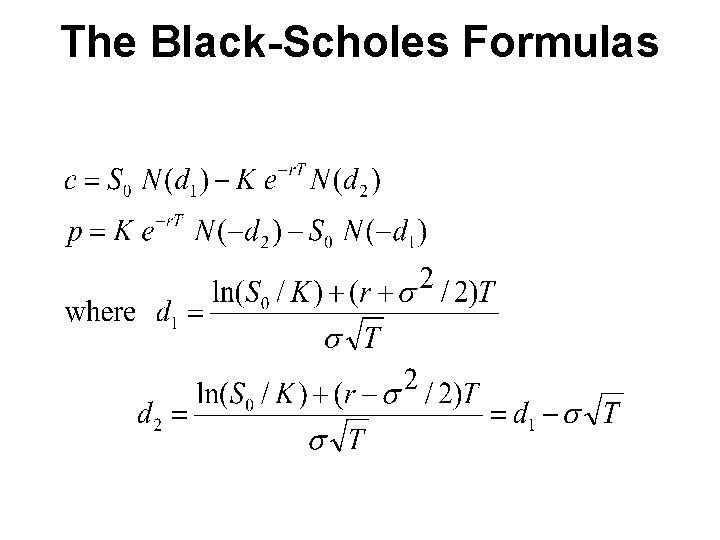

In [7]:
def black_scholes_call(S, K, T, r, sigma):
    if T < 1e-3:
        return max(S - K, 0)
        # se deduce de tomar T tendiendo a cero en el modelo

    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    call_option_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_option_price


def calculate_vega(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    vega = S * math.sqrt(T) * norm.pdf(d1)
    return vega


def make_realized_volatility_series(stock_price):
    price_series = pd.Series(stock_price)
    realized_volatility_series = price_series.rolling(window=21).apply(lambda x: np.std(np.log(x)) * np.sqrt(252))

    return realized_volatility_series.values

# Los dos metodos mas comunes para calcular la volatilidad implicita son



1.   Newton-Raphson

2.   Biseccion


Implementamos ambos para poder comparar los resultados obtenidos

In [8]:
def calculate_implied_volatility_newton(option_price, S, T, K=1033.0, r=1.00, initial_guess=np.random.uniform(0.65, 0.80), max_iterations=250, tolerance=1e-6):
    volatility = initial_guess

    if T < 0.0025:
        return 0

    for iteration in range(max_iterations):
        #precio de la option en esta iteracion
        option_price_calculated = black_scholes_call(S, K, T, r, volatility)
        # calcula vega
        vega = calculate_vega(S, K, T, r, volatility)
        # delta de precio
        price_difference = option_price_calculated - option_price
        # actuliza volatilidad
        volatility_difference = abs(option_price_calculated - option_price) / vega
        if price_difference < tolerance and volatility_difference < 1e-3:
            break

        volatility -= price_difference / vega


    return volatility


In [9]:
def calculate_implied_volatility_bisection(option_price, S, T, K=1033.0, r=1.00,lower_bound = 0.5 ,upper_bound = 2.0, max_iterations=250, tolerance=1e-6):


    # Avoiding division by zero
    if T < 0.0025:
        return 0

    for iteration in range(max_iterations):
        mid_point = (lower_bound + upper_bound) / 2.0

        # Calculate option price and vega at the midpoint
        option_price_calculated = black_scholes_call(S, K, T, r, mid_point)
        vega = calculate_vega(S, K, T, r, mid_point)

        # Update bounds based on the sign of the difference
        if option_price_calculated < option_price:
            lower_bound = mid_point
        else:
            upper_bound = mid_point

        # Check for convergence
        if abs(option_price_calculated - option_price) < tolerance: #and vega > 1e-6:
            break

    return mid_point


In [10]:
def make_volatility_series(optionPrice,stockPrice,time,strike,r):
  implied_volatility_series_netwon = []
  implied_volatility_series_bisection = []

  n = len(optionPrice)
  for i in range(n):
      #Calcula y appendea al vector de retorno
      implied_volatility = calculate_implied_volatility_newton(optionPrice[i], stockPrice[i],time[i], strike,r)

      implied_volatility_series_netwon.append(implied_volatility)

      implied_volatility_bisection = calculate_implied_volatility_bisection(optionPrice[i], stockPrice[i],time[i], strike,r)

      implied_volatility_series_bisection.append(implied_volatility_bisection)


  return np.array(implied_volatility_series_netwon),np.array(implied_volatility_series_bisection)

In [11]:
#Trabajamos con los vectores de precios y tiempos

optionPrice = data['optionPrice'].values

stockPrice  = data['stockPrice'].values

time        = data['time_to_T'].values

In [12]:
implied_volatility_series,implied_volatility_series_bis = make_volatility_series(optionPrice,stockPrice,time,1033.0,1.0)

realized_volatility_series =  make_realized_volatility_series(stockPrice)

<ipython-input-8-6899649c25ee>:15: RuntimeWarning: divide by zero encountered in double_scalars
  volatility_difference = abs(option_price_calculated - option_price) / vega
<ipython-input-8-6899649c25ee>:19: RuntimeWarning: divide by zero encountered in double_scalars
  volatility -= price_difference / vega
<ipython-input-7-23a27e1c3726>:6: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
<ipython-input-7-23a27e1c3726>:14: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
<ipython-input-7-23a27e1c3726>:6: RuntimeWarning: overflow encountered in double_scalars
  d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
<ipython-input-7-23a27e1c3726>:14: RuntimeWarning: overflow encountered in double_scalars
  d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))


#Esos warnings son por el vega, parece que el metodo de la biseccion es un poco mas estable

In [13]:
discoveries = pd.DataFrame({'time': time, 'newton': implied_volatility_series,'bisection':implied_volatility_series_bis, 'realized': realized_volatility_series, 'stockPrice': stockPrice,'optionPrice':optionPrice})


In [14]:
discoveries

,time,newton,bisection,realized,stockPrice,optionPrice
0,0.112329,0.642983,0.642983,NaN,1209.500,297.6530
1,0.112329,0.691669,0.691669,NaN,1210.500,301.8490
2,0.112329,0.675602,0.675602,NaN,1211.750,301.8590
3,0.112329,0.691810,0.691810,NaN,1210.500,301.8590
4,0.112329,0.739657,0.739657,NaN,1206.500,301.8590
...,...,...,...,...,...,...
3260,0.000000,0.000000,0.000000,0.061715,1139.475,107.5005
3261,0.000000,0.000000,0.000000,0.058366,1136.275,107.5005
3262,0.000000,0.000000,0.000000,0.050316,1141.050,104.0005
3263,0.000000,0.000000,0.000000,0.043350,1143.500,104.0040


#Ploteamos a ver como nos fue

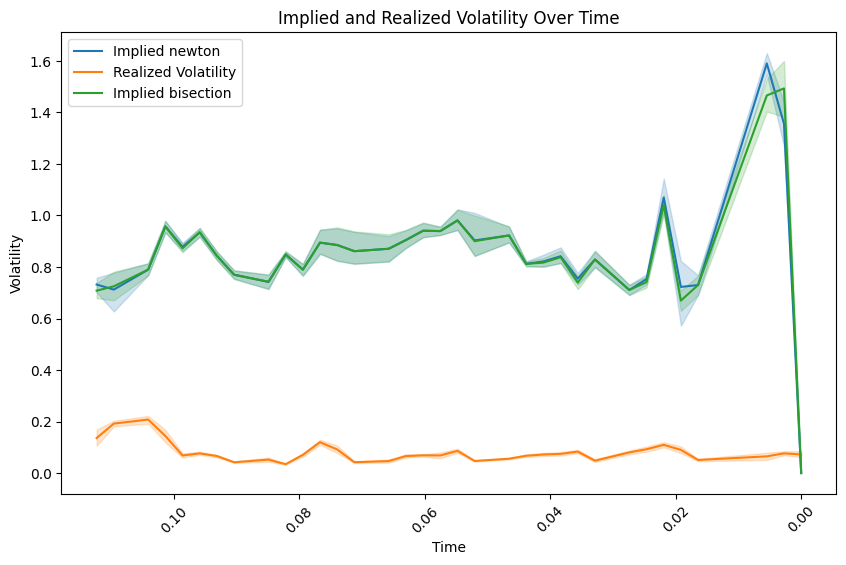

In [15]:

plt.figure(figsize=(10, 6))

sns.lineplot(data=discoveries, x='time', y='newton', label='Implied newton')

sns.lineplot(data=discoveries, x='time', y='realized', label='Realized Volatility')

sns.lineplot(data=discoveries, x='time', y='bisection', label='Implied bisection')

plt.title('Implied and Realized Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Volatility')

plt.legend()

# Rotate x-axis ticks for better readability
plt.xticks(rotation=45)
plt.gca().invert_xaxis()

plt.show()


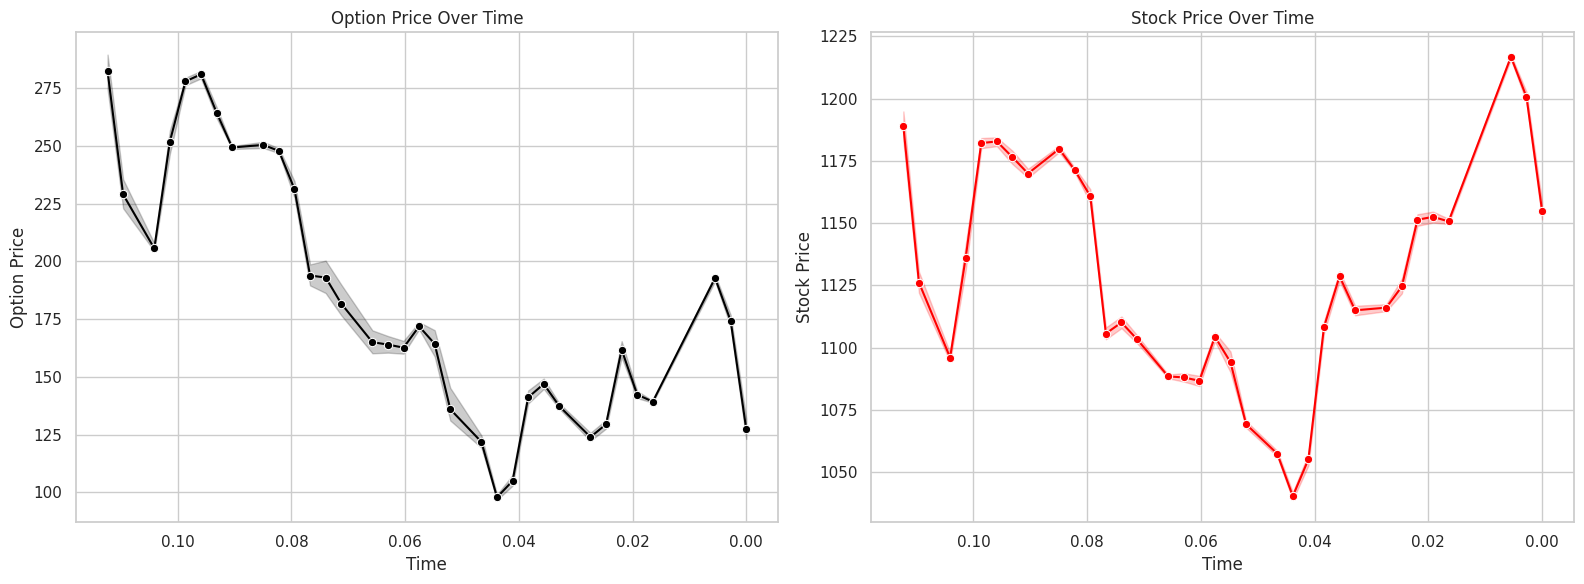

In [16]:

sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the curve of optionPrice over time
sns.lineplot(data=discoveries, x='time', y='optionPrice', color='black', marker='o', ax=axes[0])
axes[0].set_title('Option Price Over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Option Price')
axes[0].invert_xaxis()

# Plot the curve of stockPrice over time
sns.lineplot(data=discoveries, x='time', y='stockPrice', color='red', marker='o', ax=axes[1])
axes[1].set_title('Stock Price Over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Stock Price')
axes[1].invert_xaxis()

plt.tight_layout()

plt.show()


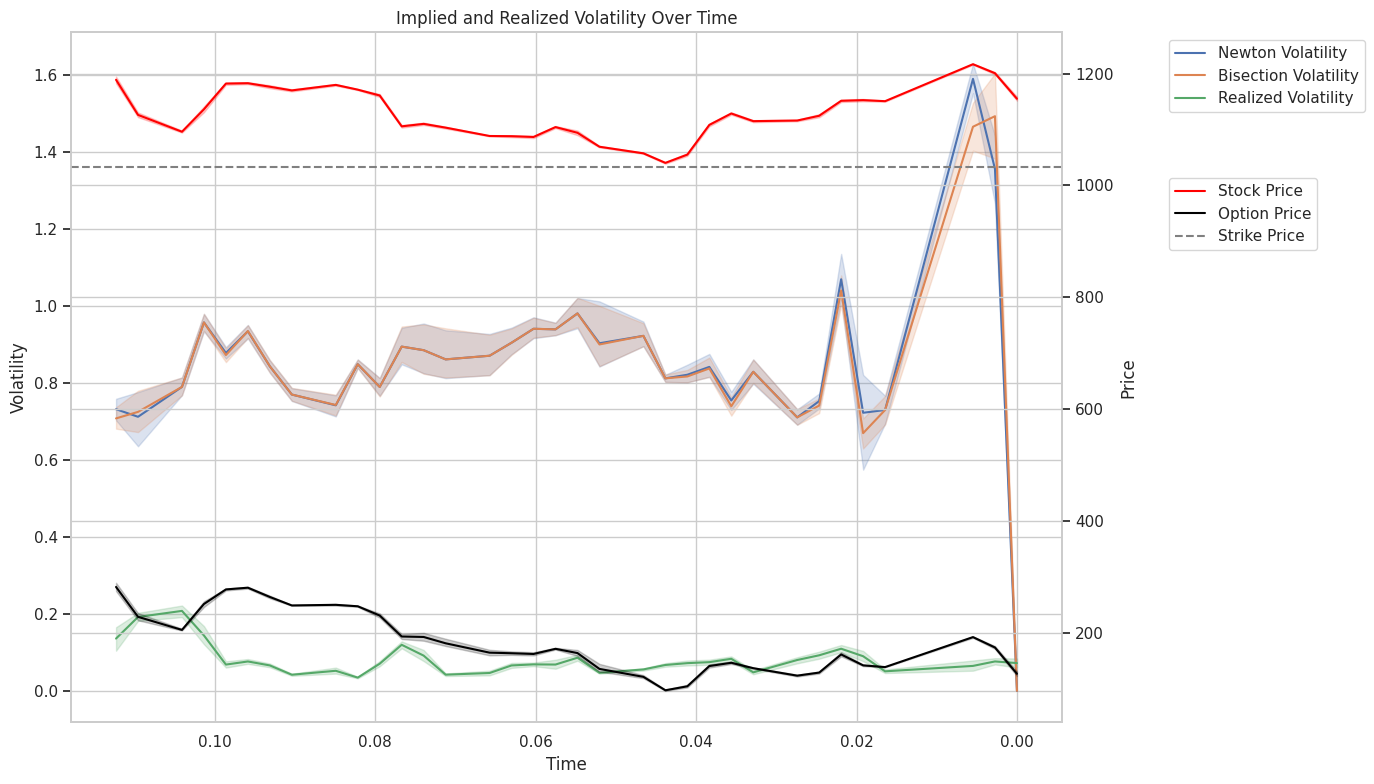

In [17]:

fig, ax1 = plt.subplots(figsize=(14, 8))

# Create smooth lines for implied and realized volatilities
sns.lineplot(data=discoveries, x='time', y='newton', label='Newton Volatility', ax=ax1)
sns.lineplot(data=discoveries, x='time', y='bisection', label='Bisection Volatility', ax=ax1)
sns.lineplot(data=discoveries, x='time', y='realized', label='Realized Volatility', ax=ax1)

# Add title and axis labels for the first y-axis
ax1.set_title('Implied and Realized Volatility Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Volatility')

# Create a secondary y-axis for the price
ax2 = ax1.twinx()
sns.lineplot(data=discoveries, x='time', y='stockPrice', color='red', label='Stock Price', ax=ax2)
sns.lineplot(data=discoveries, x='time', y='optionPrice', color='black', label='Option Price', ax=ax2)
strike_price = 1033.0
ax2.axhline(y=strike_price, color='gray', linestyle='--', label='Strike Price')
ax2.set_ylabel('Price')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='upper left', bbox_to_anchor=(1.1, 1))

# Separate legend for the second y-axis
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2, labels2, loc='upper left', bbox_to_anchor=(1.1, 0.8))



# Rotate x-axis ticks for better readability
plt.xticks(rotation=45)

plt.gca().invert_xaxis()

plt.tight_layout()

plt.show()


# Volviendo de c++ Ploteamos nuestra informacion calculada


In [18]:
#Experimento numerico que testea la funcion acumulada usada en c++

def norm_cdf(x):
    k = 1.0 / (1.0 + 0.2316419 * x)
    k_sum = k * (0.319381530 + k * (-0.356563782 + k * (1.781477937 + k * (-1.821255978 + 1.330274429 * k))))

    if x >= 0.0:
        return 1.0 - (1.0 / (math.sqrt(2 * math.pi))) * math.exp(-0.5 * x * x) * k_sum
    else:
        return 1.0 - norm_cdf(-x)

# Test the custom norm_cdf function against SciPy's norm.cdf
x_values = [-999,-99,-3,-2, -1, 0, 1,2,3,99,999]

for x in x_values:
    custom_result = norm_cdf(x)
    scipy_result = norm.cdf(x)
    print(f'x = {x}: Custom norm_cdf = {custom_result}, SciPy norm.cdf = {scipy_result}, Difference = {abs(custom_result - scipy_result)}')


x = -999: Custom norm_cdf = 0.0, SciPy norm.cdf = 0.0, Difference = 0.0
x = -99: Custom norm_cdf = 0.0, SciPy norm.cdf = 0.0, Difference = 0.0
x = -3: Custom norm_cdf = 0.0013499672222352377, SciPy norm.cdf = 0.0013498980316300933, Difference = 6.919060514440876e-08
x = -2: Custom norm_cdf = 0.022750062014251893, SciPy norm.cdf = 0.022750131948179195, Difference = 6.993392730192394e-08
x = -1: Custom norm_cdf = 0.15865525956313153, SciPy norm.cdf = 0.15865525393145707, Difference = 5.6316744601048185e-09
x = 0: Custom norm_cdf = 0.5000000005248086, SciPy norm.cdf = 0.5, Difference = 5.248086409892494e-10
x = 1: Custom norm_cdf = 0.8413447404368685, SciPy norm.cdf = 0.8413447460685429, Difference = 5.6316744601048185e-09
x = 2: Custom norm_cdf = 0.9772499379857481, SciPy norm.cdf = 0.9772498680518208, Difference = 6.993392731580172e-08
x = 3: Custom norm_cdf = 0.9986500327777648, SciPy norm.cdf = 0.9986501019683699, Difference = 6.919060513421726e-08
x = 99: Custom norm_cdf = 1.0, SciPy

In [38]:
ruta = "/content/drive/MyDrive/Black Scholes/csvs/discoveries.csv"

In [53]:
C_discoveries = pd.read_csv(ruta)
C_discoveries['time'] = discoveries['time']

In [47]:
C_discoveries

,newton,hibrid,bisection,realized,time
0,0.642984,6.429840e-01,0.642984,NaN,0.112329
1,0.691670,6.916700e-01,0.691670,NaN,0.112329
2,0.675603,6.756030e-01,0.675603,NaN,0.112329
3,0.691811,6.918110e-01,0.691811,NaN,0.112329
4,0.739658,7.396580e-01,0.739658,NaN,0.112329
...,...,...,...,...,...
3260,0.000000,2.000000e+00,0.000000,0.029590,0.000000
3261,0.000000,2.000000e+00,0.000000,0.042571,0.000000
3262,0.000000,1.105430e-75,0.000000,0.024805,0.000000
3263,0.000000,1.105430e-75,0.000000,0.014435,0.000000


Antes de plotear hacemos un scatter, estamos buscando puntos particularmente ruidosos que puedan arruinar nuestro plot, en caso de ser pocos podemos "tirarlos"

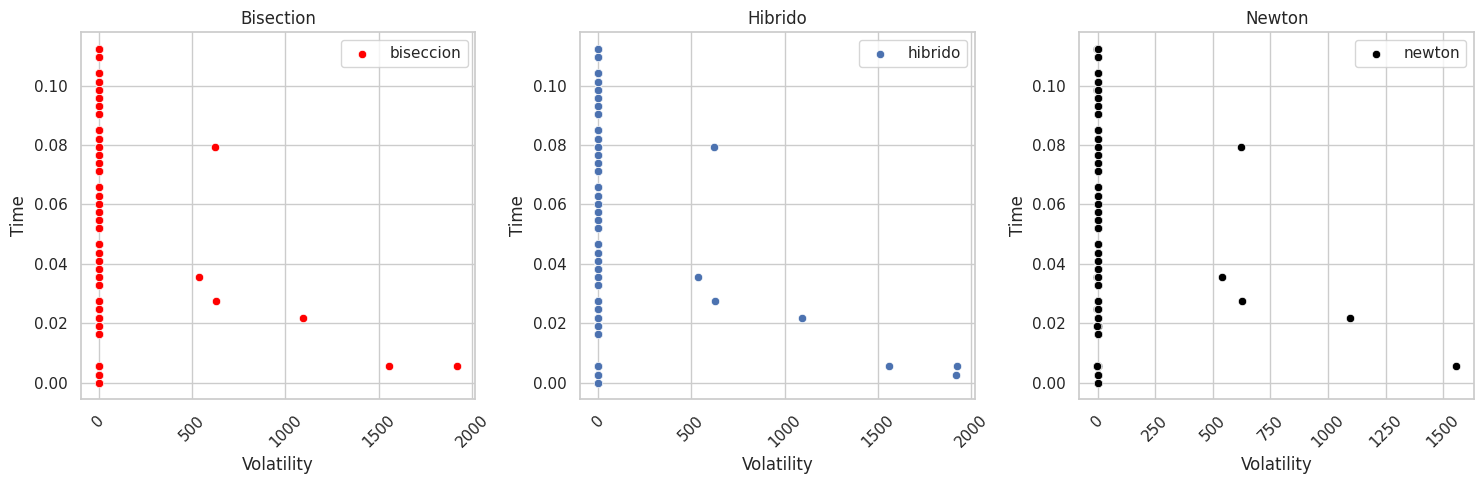

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que 'C_discoveries' es tu DataFrame con las columnas 'bisection', 'hibrid', y 'newton'

# Configurar la figura y las subfiguras
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Primer gráfico de dispersión (bisección)
sns.scatterplot(x='bisection', y='time', data=C_discoveries, label='biseccion',color = 'red', ax=axes[0])
axes[0].set_title('Bisection')
axes[0].set_ylabel('Time')
axes[0].set_xlabel('Volatility')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Segundo gráfico de dispersión (híbrido)
sns.scatterplot(x='hibrid', y='time', data=C_discoveries, label='hibrido', ax=axes[1])
axes[1].set_title('Hibrido')
axes[1].set_ylabel('Time')
axes[1].set_xlabel('Volatility')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Tercer gráfico de dispersión (Newton)
sns.scatterplot(x='newton', y='time', data=C_discoveries, label='newton',color = 'black', ax=axes[2])
axes[2].set_title('Newton')
axes[2].set_ylabel('Time')
axes[2].set_xlabel('Volatility')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# Ajustar el espaciado entre subfiguras
plt.tight_layout()

# Mostrar la figura
plt.show()


Vemos que todos los metodos tienen resultados similares y fallan aproximandamente en los mismos puntos

In [ ]:
C_discoveries = C_discoveries.applymap(lambda x: np.nan if ((x == -1) or x > 10) else x)

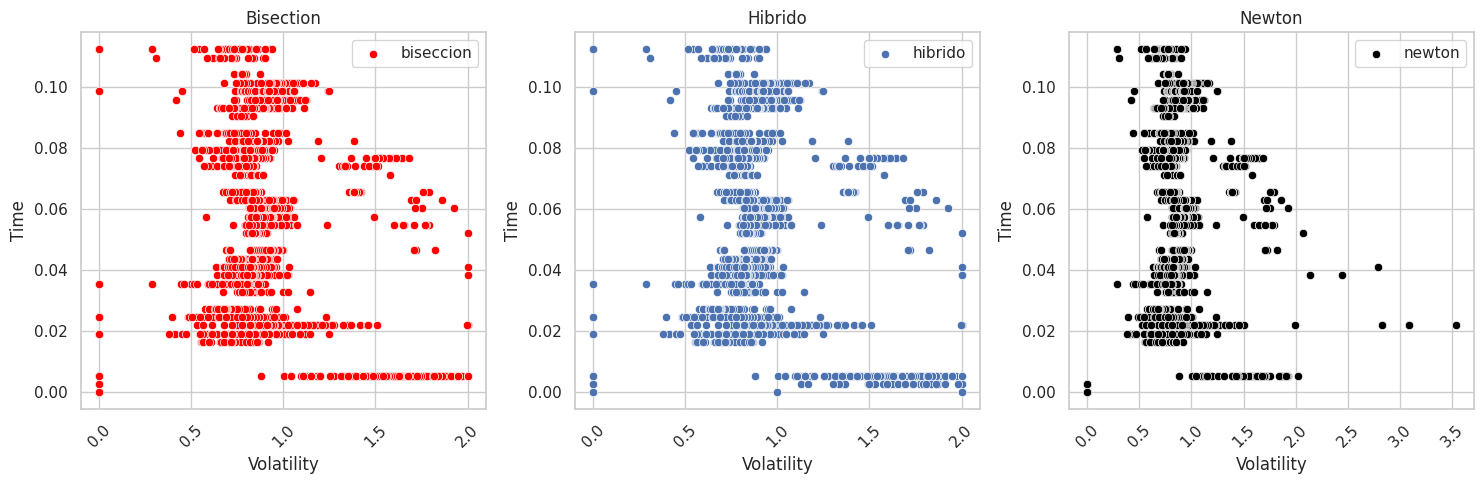

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que 'C_discoveries' es tu DataFrame con las columnas 'bisection', 'hibrid', y 'newton'

# Configurar la figura y las subfiguras
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Primer gráfico de dispersión (bisección)
sns.scatterplot(x='bisection', y='time', data=C_discoveries, label='biseccion',color = 'red', ax=axes[0])
axes[0].set_title('Bisection')
axes[0].set_ylabel('Time')
axes[0].set_xlabel('Volatility')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Segundo gráfico de dispersión (híbrido)
sns.scatterplot(x='hibrid', y='time', data=C_discoveries, label='hibrido', ax=axes[1])
axes[1].set_title('Hibrido')
axes[1].set_ylabel('Time')
axes[1].set_xlabel('Volatility')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Tercer gráfico de dispersión (Newton)
sns.scatterplot(x='newton', y='time', data=C_discoveries, label='newton',color = 'black', ax=axes[2])
axes[2].set_title('Newton')
axes[2].set_ylabel('Time')
axes[2].set_xlabel('Volatility')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# Ajustar el espaciado entre subfiguras
plt.tight_layout()

# Mostrar la figura
plt.show()


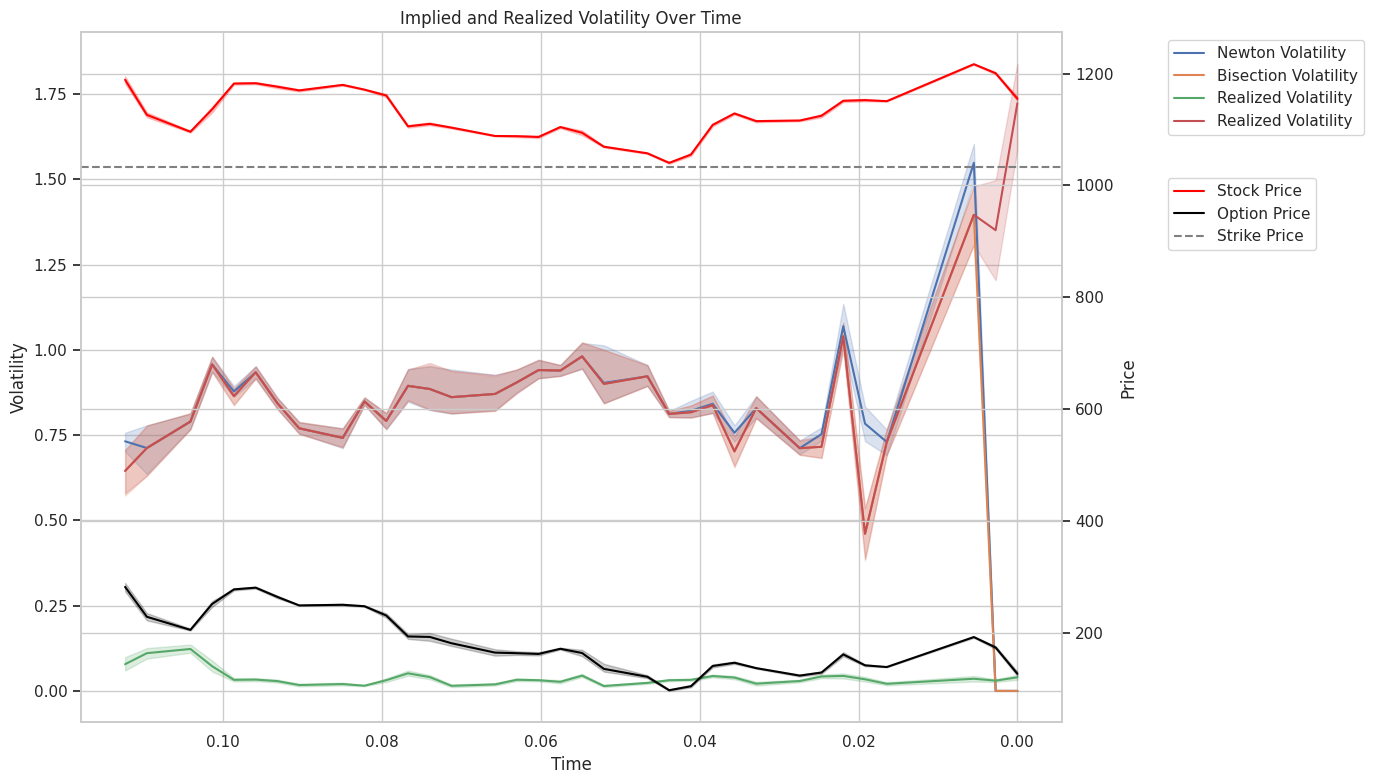

In [58]:

fig, ax1 = plt.subplots(figsize=(14, 8))

# Create smooth lines for implied and realized volatilities
sns.lineplot(data=C_discoveries, x='time', y='newton', label='Newton Volatility', ax=ax1)
sns.lineplot(data=C_discoveries, x='time', y='bisection', label='Bisection Volatility', ax=ax1)
sns.lineplot(data=C_discoveries, x='time', y='realized', label='Realized Volatility', ax=ax1)
sns.lineplot(data=C_discoveries, x='time', y='hibrid', label='Realized Volatility', ax=ax1)

# Add title and axis labels for the first y-axis
ax1.set_title('Implied and Realized Volatility Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Volatility')

# Create a secondary y-axis for the price
ax2 = ax1.twinx()
sns.lineplot(data=discoveries, x='time', y='stockPrice', color='red', label='Stock Price', ax=ax2)
sns.lineplot(data=discoveries, x='time', y='optionPrice', color='black', label='Option Price', ax=ax2)

strike_price = 1033.0
ax2.axhline(y=strike_price, color='gray', linestyle='--', label='Strike Price')
ax2.set_ylabel('Price')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='upper left', bbox_to_anchor=(1.1, 1))

# Separate legend for the second y-axis
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2, labels2, loc='upper left', bbox_to_anchor=(1.1, 0.8))



# Rotate x-axis ticks for better readability
plt.xticks(rotation=45)

plt.gca().invert_xaxis()

plt.tight_layout()

plt.show()


### Observamos que los 3 metodos tienen comportamientos similares

Si tuviera que decir algo de cada uno

Newton: converge rapidamente pero puede resultar inestable cuando el tiempo o el vega se van a cero

Biseccion: me parció el metodo mas robusto de los 3, facil de implementar
no corremos riesgos de dividir por cero en ningun momento

Hibrido: A priori pense que iba a tener mejores resultados ya que debia tomar lo mejor de los mundos, no resultó inestable porque el dato inicial fue muy bueno. Me parece que no vale el precio, al menos en este contexto de uso ya que sus resultados no justifican tener que hacer biseccion primero.


### ¿Por que es tan distinto implied y realized?

Para intentar responderlo nos vamos a los libros.

"It is important to note that the prices deep in the money and deep out of the money options are relativily insensitive to volatility. Implied volatilities calculated from these options tend, therefore to be unreliable"

john C Hull Options,Futures and Other Derivatives

Pagina 251 5ta edicion
